In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotx
import matplotlib
import jax

matplotlib.style.use(matplotx.styles.dufte)

import temporal_fusion_transformer as tft

[autoreload of wrapt.decorators failed: Traceback (most recent call last):
  File "/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _AdapterFunctionSurroga

In [7]:
data_config = tft.experiments.fixed_parameters.get_config("electricity")

In [46]:
df = pl.read_parquet("../data/electricity/test.parquet")
df

power_usage,year,month,hour,day,day_of_week,id
f32,u16,u8,u8,u8,u8,str
16.81472,2014,8,0,25,1,"""MT_001"""
16.180202,2014,8,1,25,1,"""MT_001"""
16.180202,2014,8,2,25,1,"""MT_001"""
16.81472,2014,8,3,25,1,"""MT_001"""
16.497461,2014,8,4,25,1,"""MT_001"""
16.180202,2014,8,5,25,1,"""MT_001"""
16.497461,2014,8,6,25,1,"""MT_001"""
15.545685,2014,8,7,25,1,"""MT_001"""
19.035534,2014,8,8,25,1,"""MT_001"""


In [47]:
mt_124_df = df.filter(pl.col("id").eq("MT_124"))
mt_124_df

power_usage,year,month,hour,day,day_of_week,id
f32,u16,u8,u8,u8,u8,str
346.889954,2014,8,0,25,1,"""MT_124"""
321.770325,2014,8,1,25,1,"""MT_124"""
224.880386,2014,8,2,25,1,"""MT_124"""
178.22966,2014,8,3,25,1,"""MT_124"""
129.1866,2014,8,4,25,1,"""MT_124"""
83.732056,2014,8,5,25,1,"""MT_124"""
68.181816,2014,8,6,25,1,"""MT_124"""
99.282295,2014,8,7,25,1,"""MT_124"""
129.1866,2014,8,8,25,1,"""MT_124"""


In [10]:
mt_124_df.describe()

describe,power_usage,year,month,hour,day,day_of_week,id
str,f64,f64,f64,f64,f64,f64,str
"""count""",337.0,337.0,337.0,337.0,337.0,337.0,"""337"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",337.714569,2014.0,8.501484,11.465875,15.976261,3.991098,null
"""std""",148.767532,0.0,0.500741,6.950475,12.173328,2.006665,null
"""min""",61.004784,2014.0,8.0,0.0,1.0,1.0,"""MT_124"""
"""25%""",181.818176,2014.0,8.0,5.0,4.0,2.0,null
"""50%""",386.363647,2014.0,9.0,11.0,8.0,4.0,null
"""75%""",447.368408,2014.0,9.0,17.0,28.0,6.0,null
"""max""",643.540649,2014.0,9.0,23.0,31.0,7.0,"""MT_124"""


In [11]:
mt_124_df = mt_124_df.with_columns(
    [
        pl.datetime("year", "month", "day", "hour")
        .dt.strftime("%Y/%m/%d %H:%M:%S")
        .alias("date")
        .str.to_datetime()
    ]
)

mt_124_df.describe()

describe,power_usage,year,month,hour,day,day_of_week,id,date
str,f64,f64,f64,f64,f64,f64,str,str
"""count""",337.0,337.0,337.0,337.0,337.0,337.0,"""337""","""337"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",337.714569,2014.0,8.501484,11.465875,15.976261,3.991098,null,null
"""std""",148.767532,0.0,0.500741,6.950475,12.173328,2.006665,null,null
"""min""",61.004784,2014.0,8.0,0.0,1.0,1.0,"""MT_124""","""2014-08-25 00:…"
"""25%""",181.818176,2014.0,8.0,5.0,4.0,2.0,null,null
"""50%""",386.363647,2014.0,9.0,11.0,8.0,4.0,null,null
"""75%""",447.368408,2014.0,9.0,17.0,28.0,6.0,null,null
"""max""",643.540649,2014.0,9.0,23.0,31.0,7.0,"""MT_124""","""2014-09-08 00:…"


In [12]:
max_date = mt_124_df["date"].max()
boundary = max_date - timedelta(hours=192)

mt_124_df = mt_124_df.filter(pl.col("date") >= boundary)

In [13]:
ts = mt_124_df["date"].to_list()
pu = mt_124_df["power_usage"].to_numpy()

In [48]:
pu

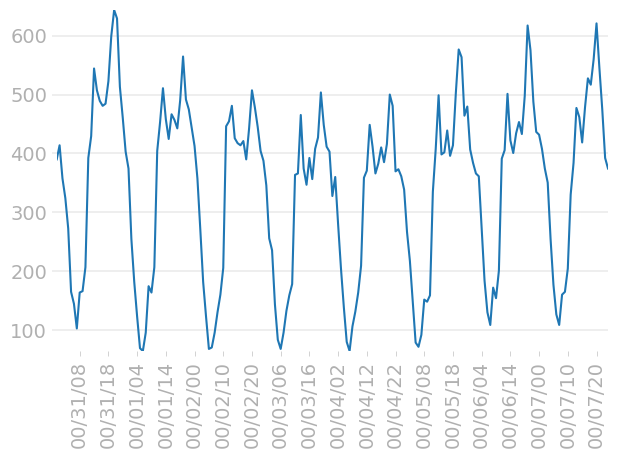

In [15]:
plt.plot(ts, pu)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%M/%d/%H"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))
plt.xticks(rotation=90)
plt.tight_layout()

In [16]:
preprocessor = tft.experiments.Electricity().reload_preprocessor(
    "/Users/artemsereda/Documents/IdeaProjects/temporal_fusion_transformer/data/electricity/preprocessor.msgpack"
)
preprocessor.preprocessor

{'categorical': {'day': LabelEncoder(),
  'day_of_week': LabelEncoder(),
  'hour': LabelEncoder(),
  'id': LabelEncoder(),
  'month': LabelEncoder()},
 'real': {'MT_001': StandardScaler(),
  'MT_002': StandardScaler(),
  'MT_003': StandardScaler(),
  'MT_004': StandardScaler(),
  'MT_005': StandardScaler(),
  'MT_006': StandardScaler(),
  'MT_007': StandardScaler(),
  'MT_008': StandardScaler(),
  'MT_009': StandardScaler(),
  'MT_010': StandardScaler(),
  'MT_011': StandardScaler(),
  'MT_012': StandardScaler(),
  'MT_013': StandardScaler(),
  'MT_014': StandardScaler(),
  'MT_015': StandardScaler(),
  'MT_016': StandardScaler(),
  'MT_017': StandardScaler(),
  'MT_018': StandardScaler(),
  'MT_019': StandardScaler(),
  'MT_020': StandardScaler(),
  'MT_021': StandardScaler(),
  'MT_022': StandardScaler(),
  'MT_023': StandardScaler(),
  'MT_024': StandardScaler(),
  'MT_025': StandardScaler(),
  'MT_026': StandardScaler(),
  'MT_027': StandardScaler(),
  'MT_028': StandardScaler(),
 

In [17]:
df_v2 = preprocessor.apply(mt_124_df)
df_v2

Applying scalers...:   0%|          | 0/193 [00:00<?, ?it/s]

Applying label encoders...:   0%|          | 0/4 [00:00<?, ?it/s]

power_usage,year,date,month,day,hour,day_of_week,id
f32,f32,datetime[μs],i8,i8,i8,i8,u16
-0.061102,0.0,2014-08-31 00:00:00,7,30,0,6,123
-0.061102,0.0,2014-08-31 01:00:00,7,30,1,6,123
-0.061102,0.0,2014-08-31 02:00:00,7,30,2,6,123
-0.061102,0.0,2014-08-31 03:00:00,7,30,3,6,123
-0.061102,0.0,2014-08-31 04:00:00,7,30,4,6,123
-0.061102,0.0,2014-08-31 05:00:00,7,30,5,6,123
-0.061102,0.0,2014-08-31 06:00:00,7,30,6,6,123
-0.061102,0.0,2014-08-31 07:00:00,7,30,7,6,123
-0.061102,0.0,2014-08-31 08:00:00,7,30,8,6,123


In [18]:
tf_ds = preprocessor.convert_dataframe_to_tf_dataset(mt_124_df)
tf_ds

Applying scalers...:   0%|          | 0/193 [00:00<?, ?it/s]

Applying label encoders...:   0%|          | 0/4 [00:00<?, ?it/s]

Converting to time-series dataset: 0it [00:00, ?it/s]

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [19]:
x, y = tf_ds.batch(8, drop_remainder=False).as_numpy_iterator().next()
x.shape, y.shape

((2, 192, 6), (2, 192, 1))

In [20]:
from temporal_fusion_transformer.src.modeling.tft_model import make_temporal_fusion_transformer
from temporal_fusion_transformer.src.experiments.configs.hyperparameters import get_config


config2 = get_config("electricity")

model = make_temporal_fusion_transformer(config2.model, data_config)
rng = jax.random.PRNGKey(0)
# params = model.init(rng, np.ones(shape=(2, 192, 6), dtype=np.float32))["params"]

In [21]:
from absl_extra.flax_utils import load_from_msgpack

reloaded_params = load_from_msgpack(None, "../data/electricity/model.msgpack")
bound_model = model.bind({"params": reloaded_params})

In [22]:
y_predicted = bound_model(x)

In [23]:
y_predicted.shape

(2, 24, 1, 3)

In [24]:
preprocessor.preprocessor["categorical"]["id"].inverse_transform([130])

array(['MT_131'], dtype='<U6')

In [28]:
from absl_extra.flax_utils import save_as_msgpack

save_as_msgpack(
    {"x_batch": x, "y_batch": y, "y_predicted": y_predicted, "id": "MT_124"}, "data.msgpack"
)

In [41]:
from temporal_fusion_transformer.src.experiments.electricity import (
    _ID_COLUMN,
    _REAL_INPUTS,
    _CATEGORICAL_INPUTS,
    _TARGETS,
)
from temporal_fusion_transformer.src.experiments.configs import fixed_parameters


def inverse_transform_for_single_id(
    _preprocessor,
    x_batch: np.ndarray,
    y_batch: np.ndarray,
    entity_id: str,
) -> pl.LazyFrame:
    config = fixed_parameters.get_config("electricity")

    print(f"{config = }")

    y_new = _preprocessor["target"][entity_id].inverse_transform(y_batch)

    x_categorical = np.take(
        x_batch, list(config.input_known_categorical_idx) + list(config.input_static_idx), axis=-1
    )

    def map_fn(i, j):
        print(f"{i = }, {j = }")
        _preprocessor["categorical"][j].inverse_transform(np.asarray(i, dtype=np.int32))

    x_categorical_new = [
        # _preprocessor["categorical"][j].inverse_transform(np.asarray(i, dtype=np.int32))
        map_fn(i, j)
        for i, j in zip(x_categorical, _CATEGORICAL_INPUTS + [_ID_COLUMN])
    ]

    x_real = np.take(
        x_batch, list(config.input_known_real_idx) + list(config.input_observed_idx), axis=-1
    )

    x_real_new = _preprocessor["real"][entity_id].inverse_transform(x_real)

    return (
        pl.DataFrame()
        .with_columns(
            [
                pl.col(j).lit(i)
                for i, j in zip(x_categorical_new, _CATEGORICAL_INPUTS + [_ID_COLUMN])
            ]
        )
        .with_columns(pl.col(j).lit(i) for i, j in zip(x_real_new, _REAL_INPUTS))
        .with_columns(pl.col(j).lit(i) for i, j in zip(y_new, _TARGETS))
        .rechunk()
    )


inverse_transform_for_single_id(
    preprocessor.preprocessor, np.reshape(x, (-1, 6)), np.reshape(y, (-1, 1)), "MT_124"
)

month,day,hour,day_of_week,id,year,power_usage
u8,u8,u8,u8,str,f32,f32
8,31,0,7,"""MT_124""",2014.0,389.952148
8,31,1,7,"""MT_124""",2014.0,389.952148
8,31,2,7,"""MT_124""",2014.0,389.952148
8,31,3,7,"""MT_124""",2014.0,389.952148
8,31,4,7,"""MT_124""",2014.0,389.952148
8,31,5,7,"""MT_124""",2014.0,389.952148
8,31,6,7,"""MT_124""",2014.0,389.952148
8,31,7,7,"""MT_124""",2014.0,389.952148
8,31,8,7,"""MT_124""",2014.0,389.952148


In [44]:
ids = np.asarray(np.reshape(x, (-1, 6))[..., 5], np.int32)
ids

(384, 1)

In [33]:
np.argwhere(ids == 123).reshape(-1).shape

power_usage
f32
389.952148
389.952148
389.952148
389.952148
389.952148
389.952148
389.952148
389.952148
389.952148


In [38]:
np.take(np.reshape(x, (-1, 6)), np.argwhere(ids == 123).reshape(-1), axis=0).shape

array([389.95215 , 413.8756  , 357.6555  , 324.1627  , 272.72726 ,
       165.0718  , 144.73686 , 102.870804, 163.8756  , 166.26796 ,
       206.93782 , 392.34448 , 429.42584 , 544.25836 , 507.17703 ,
       489.23444 , 480.86124 , 484.44977 , 522.7273  , 599.2823  ,
       643.54065 , 629.1866  , 513.1579  , 460.5263  , 403.11005 ,
       374.40192 , 254.78468 , 181.81819 , 123.205765,  69.378006,
        64.59328 ,  95.6938  , 174.64116 , 163.8756  , 206.93782 ,
       404.3062  , 453.34927 , 510.76556 , 458.13397 , 424.64114 ,
       466.50717 , 456.9378  , 442.58374 , 490.43063 , 564.5933  ,
       491.6268  , 474.88037 , 443.7799  , 412.6794  , 357.6555  ,
       271.5311  , 181.81819 , 123.205765,  68.18184 ,  70.57417 ,
        95.6938  , 130.3828  , 160.2871  , 205.74162 , 446.17224 ,
       454.54544 , 480.86124 , 425.8373  , 417.4641  , 413.8756  ,
       421.05264 , 389.95215 , 442.58374 , 507.17703 , 478.4689  ,
       444.97607 , 404.3062  , 387.5598  , 345.6938  , 255.980

In [39]:
len(np.unique(ids))

array([389.95215 , 413.8756  , 357.65552 , 324.1627  , 272.72726 ,
       165.07178 , 144.73685 , 102.87081 , 163.8756  , 166.26794 ,
       206.9378  , 392.34448 , 429.42584 , 544.25836 , 507.17703 ,
       489.23444 , 480.86124 , 484.44977 , 522.7273  , 599.2823  ,
       643.54065 , 629.1866  , 513.1579  , 460.5263  , 403.11005 ,
       374.40192 , 254.78468 , 181.81818 , 123.20574 ,  69.37799 ,
        64.5933  ,  95.69378 , 174.64114 , 163.8756  , 206.9378  ,
       404.3062  , 453.34927 , 510.76556 , 458.13397 , 424.64114 ,
       466.50717 , 456.9378  , 442.58374 , 490.43063 , 564.5933  ,
       491.6268  , 474.88037 , 443.7799  , 412.6794  , 357.65552 ,
       271.5311  , 181.81818 , 123.20574 ,  68.181816,  70.574165,
        95.69378 , 130.38278 , 160.28708 , 205.74162 , 446.17224 ,
       454.54544 , 480.86124 , 425.8373  , 417.4641  , 413.8756  ,
       421.05264 , 389.95215 , 442.58374 , 507.17703 , 478.4689  ,
       444.97607 , 404.3062  , 387.5598  , 345.6938  , 255.980

array([ True,  True, False,  True,  True, False, False, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,